In [1]:
%run ./_setup.ipynb

SyntaxError: invalid syntax (<ipython-input-1-b850dc00ac25>, line 18)

In [2]:
from matplotlib.path import Path
import scipy.interpolate

# Process bathymetry data

Here we download bathymetry of Galveston Bay, decimating by taking every 5th point in x and y so that it is easier to work with. After downloading the decimated data, it saves it to a local netcdf file (`data/bathy/topo.nc`). This process is pretty quick on a lightweight machine with decent internet connection. Note that this data is referenced to the vertical tidal datum of Mean High Water (MHW) and horizontal datum of World Geodetic System 1984 (WGS84).

The notebook saves the results of this processing for use in plots and analysis in a file called `data/bathy/bathy.nc`.

## Read in data over internet

In [3]:
# Create netCDF file of topography if it doesn't already exist
fname = baseb + 'topo.nc'

if not os.path.exists(fname):
    loc = 'https://www.ngdc.noaa.gov/thredds/dodsC/regional/galveston_13_mhw_2007.nc?crs,lat[0:5:10260],lon[0:5:10260],Band1[0:5:10260][0:5:10260]'
    ds = xr.open_dataset(loc)
    ds.to_netcdf(fname)
else:
    ds = xr.open_dataset(fname)

# rename variables and change to arrays
topo = ds['Band1'].values  # both topography and bathymetry
lon = ds['lon'].values
lat = ds['lat'].values

## Calculate cell lengths and convert to a projection

Use Albers Equal Area projection to reasonably preserve distance and match the projection of the watershed shapefiles. It is important to put the center of the projection near our area of interest.

We use the mean in each direction of the cell lengths since they are almost equal.

In [4]:
# create grid of lon/lat values
Lon, Lat = np.meshgrid(lon, lat)

# convert from lon/lat to x/y
pts = aea.transform_points(pc, Lon, Lat)
# pts = aea.transform_points(pc, Lon, Lat)
xp = pts[:,:,0]; yp  = pts[:,:,1]

# calculate average
dx = np.diff(xp, axis=1).mean()  # are all within about a meter of each other
dy = np.diff(yp, axis=0).mean()  # are all within about a meter of each other
print(dx,dy)

44.98230247902091 51.29047895793461


## Remove topography

Change to nan any value above 0 since it is on load. Rename our new array to `bathy` to signify that it is only bathymetry.

In [5]:
inds = topo > 0
bathy = topo.copy()
bathy[inds] = np.nan

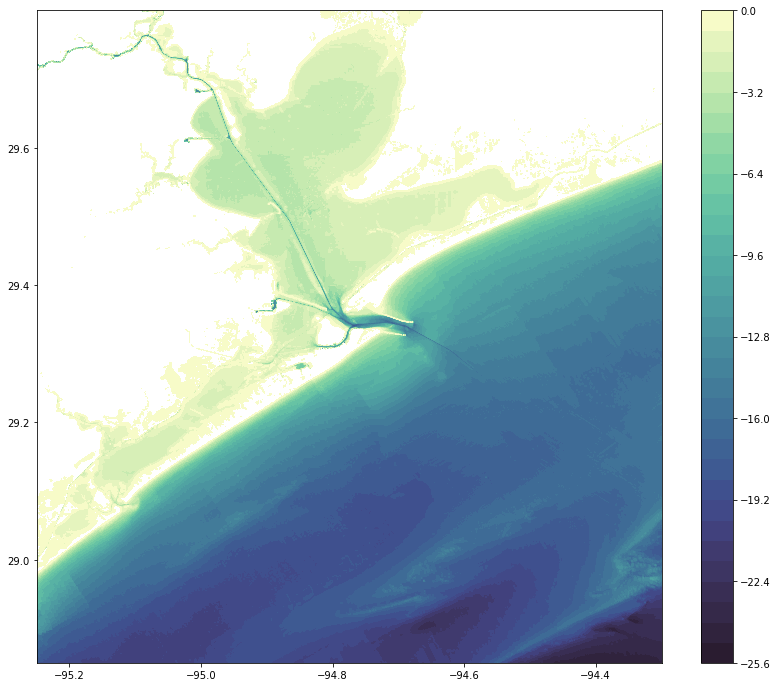

In [6]:
# now what does it look like
fig, ax = plt.subplots(figsize=(14,12))
mappable = ax.contourf(lon, lat, bathy, 40, cmap=cmo.deep_r); 
fig.colorbar(mappable)

## Remove bathymetry outside bay

We do this three ways to account for uncertainty in the surface area, including finding west and main bays separately. These three together are used to set up a Gaussian distribution of surface areas to use in the inflow calculations.

### 1. "Best" clicking version
A "best guess" outline of the bay, which attempts to remove lakes that are separate from the bay but retain connected bodies of water, has been previously clicked out by hand, using the code in the `if` statement and resulting in the file `bathy_bay_outline_best.npz`. This outline is used to remove the bathymetry points outside Galveston Bay. This is taken as the center of the Gaussian distribution of surface areas.

In [7]:
fname = baseb + 'bathy_bay_outline_best.npz'

if not os.path.exists(fname):  # manual removal
    %matplotlib auto
    fig, ax = plt.subplots(figsize=(8,7))
    mappable = ax.contourf(lon, lat, bathy, cmap=cmo.deep_r); 
    pts = plt.ginput(n=0, timeout=0)
    pts = np.asarray(list(zip(*pts))).T
    np.savez(fname, pts=pts)
else:
    pts = np.load(fname)['pts']  # in lon/lat

In [8]:
# remove extraneous points outside path

# convert ptsout from lon/lat to aea
ptsaea = aea.transform_points(pc, pts[:,0], pts[:,1])

pathout = Path(ptsaea[:,:2])
ishelf = ~pathout.contains_points(np.vstack((xp.flatten(), yp.flatten())).T).reshape(xp.shape)
bathy_best = bathy.copy()
bathy_best[ishelf] = np.nan


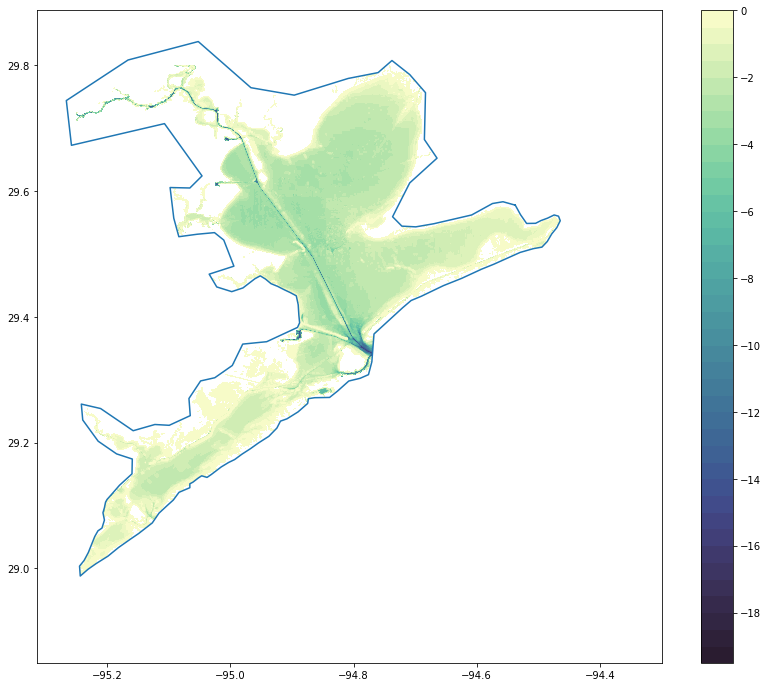

In [9]:
# now what does it look like
%matplotlib inline
fig, ax = plt.subplots(figsize=(14,12))
mappable = ax.contourf(lon, lat, bathy_best, 40, cmap=cmo.deep_r);
ax.plot(pts[:,0], pts[:,1])
fig.colorbar(mappable)

#### Separate West and Main/East bays

An outline of West Bay has also been previously found using the code in the following `if` statement.

In [10]:
fname = baseb + 'bathy_westbay_outline.npz'

if not os.path.exists(fname):  # manual removal
    %matplotlib auto
    fig, ax = plt.subplots(figsize=(10, 8))
    mappable = ax.contourf(lon, lat, bathy_best, cmap=cmo.deep_r); 
    pts = plt.ginput(n=0, timeout=0)
    np.savez(fname, pts=pts)
else:
    ptswest = np.load(fname)['pts']  # in lon/lat

In [11]:
# remove extraneous points outside west bay path to get separate
bathywest_best = bathy_best.copy()  # west bay bathy
bathymain_best = bathy_best.copy()  # rest of bay bathy

# convert ptsout from lon/lat to aea
ptswestaea = aea.transform_points(pc, ptswest[:,0], ptswest[:,1])

pathwest = Path(ptswestaea[:,:2])
inds = ~pathwest.contains_points(np.vstack((xp.flatten(), yp.flatten())).T).reshape(xp.shape)
bathywest_best[inds] = np.nan
inds = pathwest.contains_points(np.vstack((xp.flatten(), yp.flatten())).T).reshape(xp.shape)
bathymain_best[inds] = np.nan


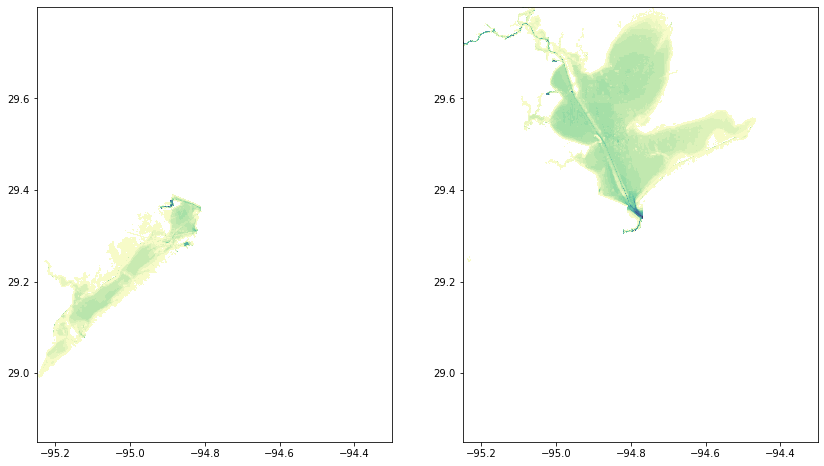

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14,8))
axes[0].contourf(lon, lat, bathywest_best, 40, cmap=cmo.deep_r); 
mappable = axes[1].contourf(lon, lat, bathymain_best, 40, cmap=cmo.deep_r); 

### Max version of surface area

Take everything that is less than 0 and inside Galveston Bay.

In [13]:
# outline bay
fname = baseb + 'bathy_bay_outline_max_version.npz'

if not os.path.exists(fname):  # manual removal
    %matplotlib auto
    fig, ax = plt.subplots(figsize=(8,7))
    mappable = ax.contourf(lon, lat, bathy, cmap=cmo.deep_r); 
    pts = plt.ginput(n=0, timeout=0)
    np.savez(fname, pts=pts)
else:
    pts = np.load(fname)['pts']  # in lon/lat

In [14]:
# remove extraneous points outside path

# convert ptsout from lon/lat to aea
ptsaea = aea.transform_points(pc, pts[:,0], pts[:,1])

pathout = Path(ptsaea[:,:2])
ishelf = ~pathout.contains_points(np.vstack((xp.flatten(), yp.flatten())).T).reshape(xp.shape)
bathy_max = bathy.copy()
bathy_max[ishelf] = np.nan

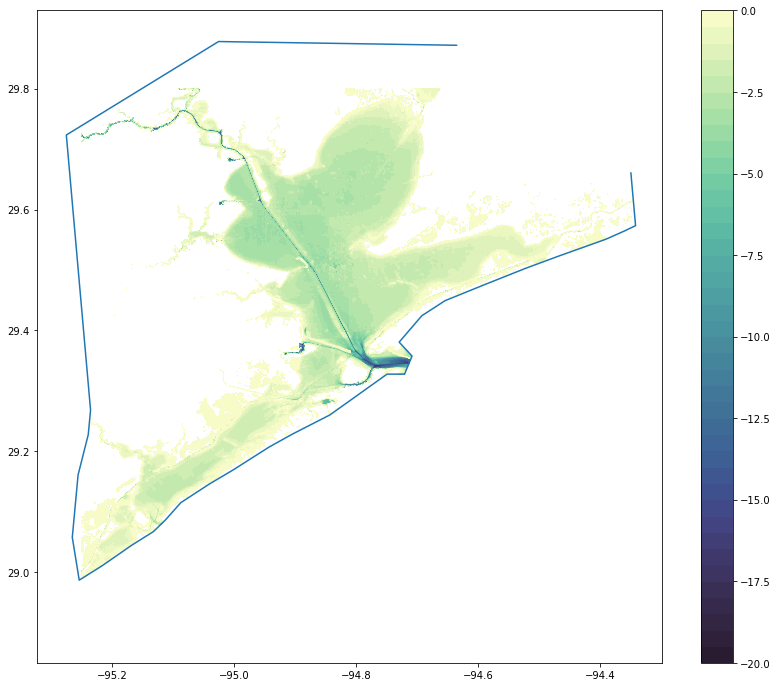

In [15]:
# now what does it look like
%matplotlib inline
fig, ax = plt.subplots(figsize=(14,12))
mappable = ax.contourf(lon, lat, bathy_max, 40, cmap=cmo.deep_r);
ax.plot(pts[:,0], pts[:,1])
fig.colorbar(mappable)

#### Separate West and Main/East bays

We use the same outline of West Bay for this bathy set too.

In [16]:
fname = baseb + 'bathy_westbay_outline.npz'

ptswest = np.load(fname)['pts']  # in lon/lat

In [17]:
# remove extraneous points outside west bay path to get separate
bathywest_max = bathy_max.copy()  # west bay bathy
bathymain_max = bathy_max.copy()  # rest of bay bathy

# convert ptsout from lon/lat to aea
ptswestaea = aea.transform_points(pc, ptswest[:,0], ptswest[:,1])

pathwest = Path(ptswestaea[:,:2])
inds = ~pathwest.contains_points(np.vstack((xp.flatten(), yp.flatten())).T).reshape(xp.shape)
bathywest_max[inds] = np.nan
inds = pathwest.contains_points(np.vstack((xp.flatten(), yp.flatten())).T).reshape(xp.shape)
bathymain_max[inds] = np.nan


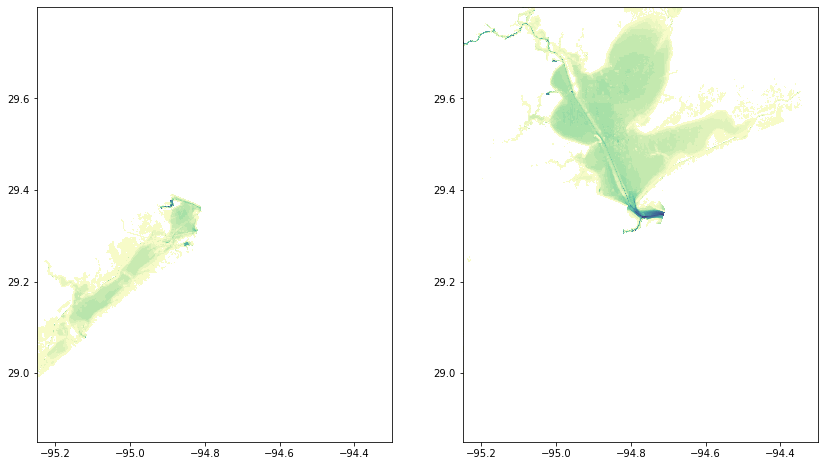

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14,8))
axes[0].contourf(lon, lat, bathywest_max, 40, cmap=cmo.deep_r); 
mappable = axes[1].contourf(lon, lat, bathymain_max, 40, cmap=cmo.deep_r); 

### Minimum surface area (for West Bay): defined by TWDB bays

Use watershed basins from TWDB to define West Bay and Main Bay. This automatically separates in West and main bays.

In [19]:
twdbshapes = 'galv_ws_nad83_prj_albers_equal_area_conic_USGS'
fname = '%s%s/%s.shp' % (basesf, twdbshapes, twdbshapes)

In [20]:
# Define West Bay
iwest = [24240, 24320]  # in idgb
reader = cartopy.io.shapereader.Reader(fname)
basins = reader.records()

westbasins = []
for basin in basins:
    if basin.attributes['WS_ID'] in iwest:
        westbasins.append(basin)

# combine watersheds into 1 polygon
westbasin = shapely.ops.unary_union([westbasin.geometry for westbasin in westbasins])

# find x/y points in array that are within westbasin polygon
# convert to matplotlib path since way faster than shapely contains
xywest = np.array(westbasin.exterior.xy).T  # tuple to array to be Nx2
pathout = Path(xywest)
ibathywest = pathout.contains_points(np.vstack((xp.flatten(), yp.flatten())).T).reshape(xp.shape)

# nan out non West Bay points to preserve array structure
bathywest_min = bathy.copy()
bathywest_min[~ibathywest] = np.nan

In [21]:
# Define Main Bay (includes East)
imain = [24260,24220,24210,24230,24250,24390]
reader = cartopy.io.shapereader.Reader(fname)

basins = reader.records()
mainbasins = []
for basin in basins:
    if basin.attributes['WS_ID'] in imain:
        mainbasins.append(basin)

# combine watersheds into 1 polygon. Need buffer because polygons do not fully intersect
mainbasin = shapely.ops.unary_union([mainbasin.geometry.buffer(300) for mainbasin in mainbasins])

# convert to matplotlib path since way faster than shapely contains (27 min vs. 50 seconds)
xymain = np.array(mainbasin.exterior.xy).T  # tuple to array to be Nx2
pathout = Path(xymain)
ibathymain = pathout.contains_points(np.vstack((xp.flatten(), yp.flatten())).T).reshape(xp.shape)

# nan out non Main Bay points to preserve array structure
bathymain_min = bathy.copy()
bathymain_min[~ibathymain] = np.nan

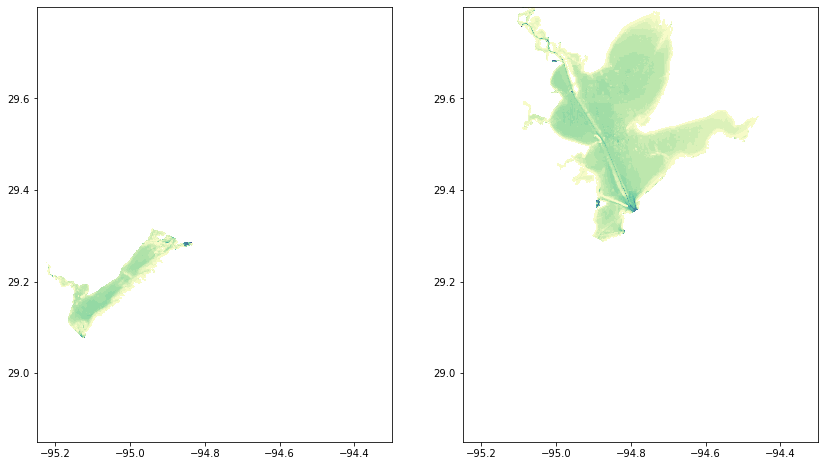

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14,8))
axes[0].contourf(lon, lat, bathywest_min, 40, cmap=cmo.deep_r); 
mappable = axes[1].contourf(lon, lat, bathymain_min, 40, cmap=cmo.deep_r);


# Surface area, depth, volume

## All of Galveston Bay

Assuming that there wasn't a significant amount of new land flooded.

In [23]:
# store different versions of bathy together in an array, 2053 x 2053 x 4
bathymains = np.stack((bathymain_best, bathymain_max, bathymain_min), axis=-1)
bathywests = np.stack((bathywest_best, bathywest_max, bathywest_min), axis=-1)

# surface area
Aall = (~np.isnan(bathymains) + ~np.isnan(bathywests)).sum(axis=(0,1))*dx*dy/1000**2  # km^2
# average depth
Hall = -np.nanmean(np.stack((bathymains, bathywests), axis=0), axis=(0,1,2))  # m
# average volume
Vall = (Aall*Hall)/1000  # km^3

# definitions for creating distribution of surface area values later
A_center = Aall[0]  # use "best" bathy for center of surface area distribution
# Difference between max and min is two standard deviations
# Use these to make a gaussian distribution of surface areas from which each surface area will be selected.
A_std = (Aall.max() - Aall.min())/2

print(A_center,A_std, (A_std/A_center)*100)

print('Full bay areas [km^2]', Aall)
print('Average depth [m]', Hall)
print('Volume [km^3]', Vall)

1558.7060464965136 143.5425053935162 9.209081193734708
Full bay areas [km^2] [1558.7060465  1679.37994392 1392.29493313]
Average depth [m] [2.2371786 2.18621   2.3346581]
Volume [km^3] [3.48710375 3.67147709 3.25053271]


In [37]:
(Aall[1] - Aall[2])/Aall[0]

0.18418162387469414

## Main bay

In [24]:
# surface area
Amain = (~np.isnan(bathymains)).sum(axis=(0,1))*dx*dy/1000**2  # km^2
# average depth
Hmain = -np.nanmean(bathymains, axis=(0,1))  # m
# average volume
Vmain = (Amain*Hmain)/1000  # km^3

# definitions for creating distribution of surface area values later
A_main_center = Amain[0]  # use "best" bathy for center of surface area distribution
# Difference between max and min is two standard deviations
# Use these to make a gaussian distribution of surface areas from which each surface area will be selected.
A_main_std = (Amain.max() - Amain.min())/2

print(A_main_center,A_main_std, (A_main_std/A_main_center)*100)

print('Main bay areas [km^2]', Amain)
print('Average depth [m]', Hmain)
print('Volume [km^3]', Vmain)

1164.312538404 46.75928952054767 4.016042770152051
Main bay areas [km^2] [1164.3125384  1257.83111745 1190.59113453]
Average depth [m] [2.5211763 2.4731808 2.4751508]
Volume [km^3] [2.93543722 3.11084373 2.94689263]


## West Bay

In [25]:
# surface area
Awest = (~np.isnan(bathywests)).sum(axis=(0,1))*dx*dy/1000**2  # km^2
# average depth
Hwest = -np.nanmean(bathywests, axis=(0,1))  # m
# average volume
Vwest = (Awest*Hwest)/1000  # km^3

# definitions for creating distribution of surface area values later
A_west_center = Awest[0]  # use "best" bathy for center of surface area distribution
# Difference between max and min is four standard deviations
# Use these to make a gaussian distribution of surface areas from which each surface area will be selected.
A_west_std = (Awest.max() - Awest.min())/2
print(A_west_center,A_west_std, (A_west_std/A_west_center)*100)

print('West bay areas [km^2]', Awest)
print('Average depth [m]', Hwest)
print('Volume [km^3]', Vwest)
print('West Bay volumes are % of full bay volume', (Vwest/Vall*100))

394.39350809251346 109.49799578848324 27.763640511749532
West bay areas [km^2] [394.39350809 421.54882647 202.5528349 ]
Average depth [m] [1.3974499 1.3273249 1.5075606]
Volume [km^3] [0.55114515 0.55953224 0.30536068]
West Bay volumes are % of full bay volume [15.80524091 15.23997636  9.39417329]


# Demonstrate distribution of surface areas

We create a distribution of surface area values to account for uncertainty. The center of each distribution is taken as the "best" bathymetry selection (#1 above). Twice the standard deviation is the difference between the max and min value. Below, a distribution is displayed and it was sampled at the three discrete values that were previously found to find the number of times to use each in the final calculation, assuming this distribution, and that we would use the least likely value once. This resulted in a ratio of 2 of the "best" bathymetry to 1 of the "max" bathymetry and 1 of the "min" bathymetry.

Vertical lines in the plot below show the three input values for each distribution.

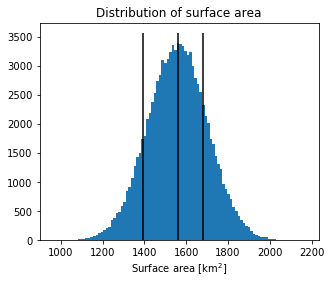

In [26]:
# Gaussian distribution of surface areas
nareas = 100000
# full bay
loc = A_center; scale = A_std
pdf = norm(loc=loc, scale=scale)
As = pdf.rvs(nareas)

fig, ax = plt.subplots(1, 1, figsize=(5,4))
n, bins, _ = ax.hist(As, bins=100);
ax.set_title('Distribution of surface area')
ax.set_xlabel('Surface area [km$^2$]')
ylims = ax.get_ylim()
ax.vlines(Aall, 0, ylims[1])


In [27]:
main0 = n[np.where(bins>=Aall[0])[0][0]]
main1 = n[np.where(bins>=Aall[1])[0][0]]
main2 = n[np.where(bins>=Aall[2])[0][0]]
# main3 = n[np.where(bins>=Aall[3])[0][0]]
main0/main2, main1/main2, main2/main2#, main3/main3

(1.8797996661101837, 1.1903171953255425, 1.0)

# Cross-sectional Area of Entrance Channel

Calculate a few numbers describing the approximate cross-sectional area of the Galveston Bay entrance channel, for use in evaluating the final inflow result.

We select the cross-sectional slice in lat/lon out of convenience since the slice is easy to define.

In [28]:
inds = topo > 0
bathynotbay = topo.copy()
bathynotbay[inds] = np.nan
ilonchannel = (lon < -94.7) * (lon > -94.83)
ilatchannel = (lat > 29.32) * (lat < 29.38)
# combined array of indices to target entrance channel area
illchannel = np.outer(ilonchannel, ilatchannel)
bathynotbay2 = bathynotbay[illchannel]

# setup up input data, needs to be Nx2
xyin = np.vstack((xp[illchannel].flat, yp[illchannel].flat)).T

# can choose slice in lat/lon but then interpolate in projection
latslice = np.linspace(29.33, 29.38, 400)
lonslice = np.ones(latslice.size)*buoys['g06010']['ll'][0]

# transform slice to projection
pts = aea.transform_points(pc, lonslice, latslice)

# need it to be Nx2
aeaslice = np.vstack((pts[:,0].flat, pts[:,1].flat)).T

# do the interpolation
Zslice = scipy.interpolate.griddata(xyin, bathynotbay2.flat, aeaslice, method='linear', fill_value=0)

In [29]:
# only keep depths within any nans since jetty is in there too
# also remove below 4m since channel widens on ebb and flow may not fill in that area
ichannel = np.arange(60,225)  # indices to keep

# average depth across channel
Hcs = abs(Zslice[ichannel].mean())
print('Average cross-channel depth: %2.1fm' % Hcs)

# distance across channel
dist = np.sqrt((pts[ichannel,0] - pts[ichannel[0],0])**2 + (pts[ichannel,1] - pts[ichannel[0],1])**2)
print('Cross-channel distance: %2.1fkm' % (dist[-1]/1000))

# calculate dslice distance between points along cross-sectional area
dslice = np.diff(dist).mean()

# constant cross-sectional area to MHW
Acs0 = abs(Hcs*dist[-1])
print('Constant cross-sectional area: %2.0f m^2' % Acs0)

Average cross-channel depth: 11.3m
Cross-channel distance: 2.3km
Constant cross-sectional area: 25738 m^2


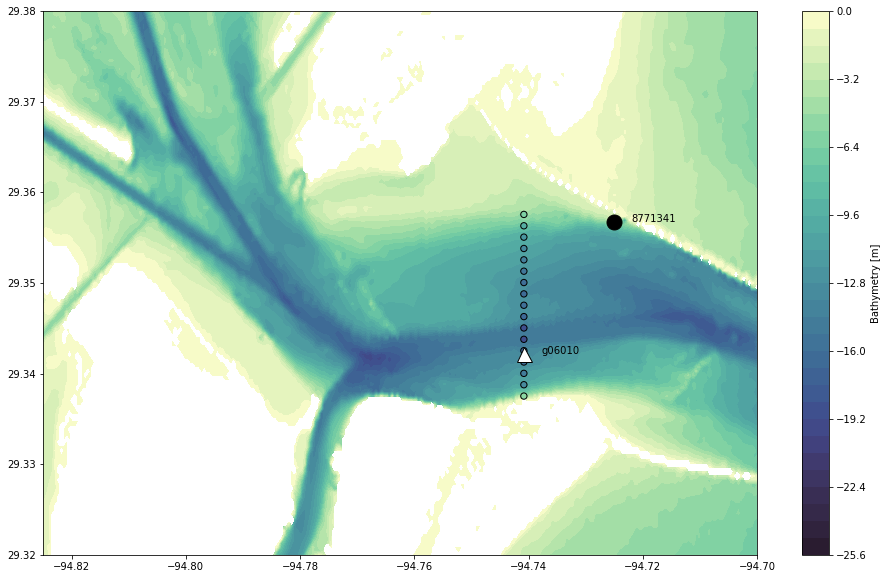

In [30]:
# check interpolation
fig, ax = plt.subplots(1,1, figsize=(16,10))

mappable = ax.contourf(lon, lat, bathynotbay, 40, cmap=cmo.deep_r); 
ax.set_ylim(29.32, 29.38)
ax.set_xlim(-94.825,-94.7)

# velocity station
ax.plot(*buoys['g06010']['ll'], '^', markersize=15, mfc='w', mec='k')
ax.text(buoys['g06010']['ll'][0]+0.003, buoys['g06010']['ll'][1], 'g06010')

ax.plot(*buoys['8771341']['ll'], 'ko', markersize=15)
ax.text(buoys['8771341']['ll'][0]+0.003, buoys['8771341']['ll'][1], '8771341')

cb = fig.colorbar(mappable)
cb.set_label('Bathymetry [m]')

dd = 10  # skip some to plot
ax.scatter(lonslice[ichannel][::dd], latslice[ichannel][::dd], c=Zslice[ichannel][::dd], s=40, cmap=cmo.deep_r, 
           vmin=-20, vmax=0, edgecolor='k')

# Save file

Add these new variables to the dataset and save to a netCDF file.

In [31]:
fname = baseb + 'bathy.nc'
if not os.path.exists(fname):

    # drop old variable
    ds = ds.drop('Band1')
    
    # add dimension for bathy types
    ds = ds.assign_coords(nbathys=np.arange(0,4))

    # add new bathy arrays
    ds['all'] = (('lat','lon'), bathy)  # data with topo nan'ed out
    ds['main'] = (('lat','lon','nbathys'), bathymains)  # bathys in main and east bays
    ds['west'] = (('lat','lon','nbathys'), bathywests)  # bathy in west bay
    # have masked array for plotting at boundary between land and water
    ds['mask'] = (('lat','lon'), np.ma.masked_where(topo>0, topo).mask)
    
    # add in surface areas and associated mean depths
    ds['Amain'] = (('nbathys'), Amain)  # km^2
    ds['Awest'] = (('nbathys'), Awest)  # km^2
    ds['Hmain'] = (('nbathys'), Hmain)  # m
    ds['Hwest'] = (('nbathys'), Hwest)  # m

    # add in scalars
    ds.attrs['Acs0'] = Acs0  # cross-sectional area of entrance channel
    ds.attrs['Dcs'] = dist[-1]  # distance across the entrance channel
    ds.attrs['dx'] = dx  # delta distance in x direction, meters
    ds.attrs['dy'] = dy  # delta distance in y direction, meters
    ds.attrs['A_center'] = A_center*1000**2  # best surface area to use as center of distribution, m^2
    ds.attrs['A_std'] = A_std*1000**2  # std to use for surface area distribution, m^2

    # save netcdf file
    ds.to_netcdf(fname)